following from http://andrewgaidus.com/Finding_Related_Wikipedia_Articles/
and the notebook https://github.com/agaidus/wikipedia_article_similarity/blob/master/Finding_Related_Wikipedia_Articles.ipynb

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
%matplotlib inline

# Word Count Vectors

One way to represent a text document is to count the instances of every word in the document. 

Then articles can be compared based on how similar their word count vectors are.

In [3]:
wiki_data = pd.read_csv('corpora/wiki_people.csv', index_col='name')['text']
print(len(wiki_data))
print 
print(wiki_data.head())

53164
name
Mark Spencer (politician)    mark steven spencer born 20 january 1970is an ...
Madison U. Sowell            madison u sowell is the provost at southern vi...
Harry B. Luthi               harry b luthi sr born 1933 is a retired busine...
Abou Diaby                   vassiriki abou diaby french pronunciation abu ...
Roger Sedarat                roger sedarat is an iranianamerican poet he is...
Name: text, dtype: object


In [4]:
nyt_c = pd.read_csv('nyt_copy.csv', index_col='Date')['Contents']
print(len(nyt_c))
print 
print(nyt_c.head())

1720
Date
2000-01-02    EVEN people with faith in nothing, people who ...
2000-01-06    Correction Appended\r\nTENEMENTS, yes. Luxury ...
2000-01-14    Two years ago, Joe, the man I lived with, sugg...
2000-01-20    IF they didn't play their luck out in furnitur...
2000-01-26    FOR years, Tequila's on Columbus held out a we...
Name: Contents, dtype: object


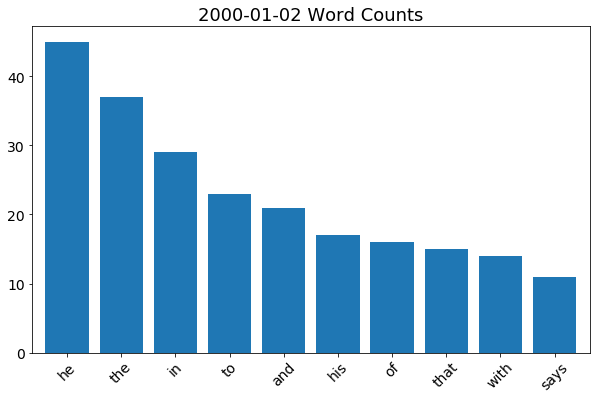

In [6]:
date = '2000-01-02'
#Extract text for a particular person
text = nyt_c[date]
#Define the count vectorizer that will be used to process the data
count_vectorizer = CountVectorizer()
#Apply this vectorizer to text to get a sparse matrix of counts
count_matrix = count_vectorizer.fit_transform([text])
#Get the names of the features
features = count_vectorizer.get_feature_names()
#Create a series from the sparse matrix
d = pd.Series(count_matrix.toarray().flatten(), 
              index = features).sort_values(ascending=False)

ax = d[:10].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=45,
            title='2000-01-02 Word Counts')
ax.title.set_size(18)

# TF-IDF Vectors

"Term frequency-inverse document frequency is a statistic that reflects how important a word is to a specific document relative to all of the words in a collection of documents (the corpus). 

The tf-idf value increases proportionally to the number of times that word appears in the document, but is offset by the frequency of the word in the corpus."

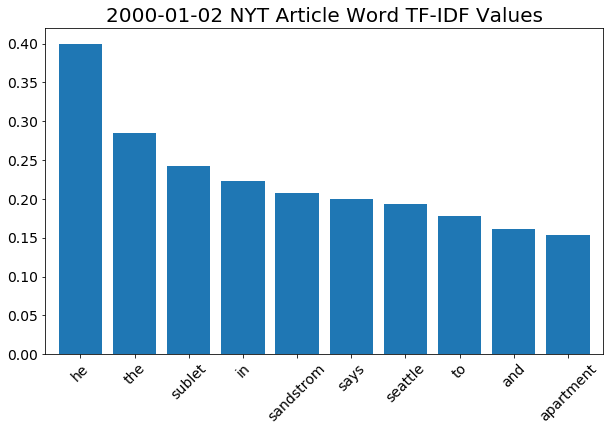

In [21]:
#Define the TFIDF vectorizer that will be used to process the data
tfidf_vectorizer = TfidfVectorizer()
#Apply this vectorizer to the full dataset to create normalized vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(nyt_c.values.astype('U'))
#Get the names of the features
features = tfidf_vectorizer.get_feature_names()
#get the row that contains relevant vector
row = nyt_c.index.get_loc(date)
#Create a series from the sparse matrix
d = pd.Series(tfidf_matrix.getrow(row).toarray().flatten(), index = features).sort_values(ascending=False)

ax = d[:10].plot(kind='bar', title='2000-01-02 NYT Article Word TF-IDF Values',
            figsize=(10,6), width=.8, fontsize=14, rot=45 )
ax.title.set_size(20)

In [23]:
#nyt_c['2000-01-02']

In [24]:
tfidf_matrix

<1720x73333 sparse matrix of type '<class 'numpy.float64'>'
	with 1111523 stored elements in Compressed Sparse Row format>

# Using K-Nearest Neighbors to Identify Similar Articles

"The NearestNeighbors function can be fit on this sparse matrix and will determine the distance between articles based on their TF-IDF values. 

I specify that I want to return the 10 nearest neighbors for each article. By default, this function uses Minkowski distance."

In [25]:
nbrs = NearestNeighbors(n_neighbors=10).fit(tfidf_matrix)

def get_closest_neighs(date):
    row = nyt_c.index.get_loc(date)
    distances, indices = nbrs.kneighbors(tfidf_matrix.getrow(row))
    names_similar = pd.Series(indices.flatten()).map(nyt_c.reset_index()['Date'])
    result = pd.DataFrame({'distance':distances.flatten(), 'date':names_similar})
    return result

In [27]:
print(get_closest_neighs('2000-01-02'))

         date  distance
0  2000-01-02  0.000000
1  2002-09-10  0.977928
2  2003-03-30  0.978358
3  2001-09-24  0.978393
4  2008-03-02  0.979737
5  2008-04-20  0.983461
6  2003-10-19  0.986013
7  2009-05-10  0.987148
8  2007-05-13  0.987827
9  2002-10-13  0.988931


In [29]:
nyt_c['2003-03-30']

"Correction Appended\r\nTHE man in the black knit cap wanted to break the bad news, but first he had to out-shout the guy on the saxophone.\r\n''We're going to have to find a new place,'' the man in the cap, Alex Saavedra, bellowed glumly to a visitor at Uncle Joe's, a tiny bar nestled among the warehouses downtown here. ''They're turning Wednesdays into House Night.''\r\nMr. Saavedra -- the 27-year old founder of Eyeball Records, based in Kearny -- was not even sure what house music is. But he was sure it would be an excellent way to kill off what had taken hold in the unlikely place that had become a hangout for him and dozens of other tattooed, pierced young people who want to hear tomorrow's music today.\r\nFor a year and a half, Uncle Joe's has been at the center of a much larger phenomenon: Jersey City has become unmistakably hip..\r\n''It's been kind of amazing to watch, to see this transformation,'' said Ralph Cuseglio, 27, who attended high school here and is now the lead sing